In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
import collections
np.random.seed(42)

import math

In [2]:
# Load in processed full text of the court cases

df=pd.read_pickle('./assets/processed_text')

In [3]:
df.shape

(247, 41)

In [4]:
# Drop cases that lack all case citation information

df=df.dropna(subset=['citation'])

In [5]:
# Clean up the citation entries, so that they are strings, not strings 
# contained in a list.

df['citation']=df['citation'].map(lambda x: x[0])

In [6]:
df=df.drop_duplicates(subset=['citation'])

In [7]:
def make_tagged_document(row):
    return TaggedDocument(words=row['text2'],
                          tags=[row['id']])
    

In [8]:
tagged_data=df.apply(lambda row: make_tagged_document(row), axis=1)

In [9]:

model = Doc2Vec(vector_size=40,  
                min_count=20,
                epochs=40,
               dm=0)


In [10]:
model.build_vocab(tagged_data)

In [11]:
model.train(tagged_data,
           total_examples=model.corpus_count,
           epochs=model.epochs)


In [12]:
# Assemble document vectors into a list

doc_vectors=[model.docvecs[i] for i in df.index]


In [13]:
# Stack dcoument vectors into a 2-D array

X=np.vstack(doc_vectors)

In [14]:
# Put the Doc2Vec embeddings into a dedicated dataframe

dfX=pd.DataFrame(X, index=df['citation'])

In [15]:
# Calculate cosin distance between each circuit court case
# in terms of Word2Vec embeddings

distances=pairwise_distances(dfX, metric='cosine')

In [16]:
# Organize distances into a dataframe

df_distances=pd.DataFrame(distances, index=dfX.index, columns=dfX.index)

In [17]:
# Import inter-case distances, in terms of 
# similar patterns of case citation, i.e., cases that were 
# similarly cited/recommended by users (i.e., lower courts)

rec_distances=pd.read_pickle('./assets/case_recommender')

In [18]:
# Remove a duplicate row that was lurking in the table

rec_distances=rec_distances.drop_duplicates().T.drop_duplicates().T

In [19]:
# The support for the two different pair distance matrices is not 
# quite the same.  Can only compare for the subset of court cases
# for which we have inter-case distances based both on similar Word2Vec
# embeddings and based on similiar citation.

overlap=list(set(rec_distances.columns)&set(df_distances.columns))

In [20]:
word_distances=df_distances[overlap].T[overlap].T

In [21]:
cite_distances=rec_distances[overlap].T[overlap].T

In [22]:
word_distances.shape

(126, 126)

In [23]:
cite_distances.shape

(126, 126)

In [24]:
corr_list=[]
for item in word_distances.columns:
    xvals=[x for x in cite_distances[item] if x != 0]
    yvals=[y for y in word_distances[item] if y != 0]

    corr_list+=[np.corrcoef(xvals, yvals)[0][1]]

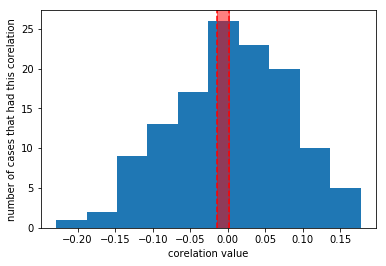

In [25]:
plt.hist(corr_list, bins=10)
plt.axvline(-.015, color="red", ls='--')
plt.axvline(.0015, color="red", ls='--')
plt.axvspan(-.015, .0015, alpha=0.5, color='red')
plt.xlabel('corelation value')
plt.ylabel('number of cases that had this corelation')
plt.savefig('./assets/avgcorr2')

In [26]:
np.mean(corr_list)

0.0042299176331083346

# B. Run a bootstrapping analysis to understand the variability of the average correllation.

-0.009855791298546843
0.018051702575849003
0.004097955866315123


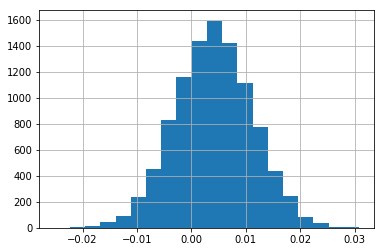

In [27]:

len(corr_list)

def get_bootstrap_mean(corr_list):
    newlist=[]
    for i in range(len(corr_list)):
        newlist.append(np.random.choice(corr_list))
    return np.mean(newlist)

boot_mean_list=[]
for i in range(10000):
    boot_mean_list.append(get_bootstrap_mean(corr_list))

boot_means=pd.Series(boot_mean_list)

boot_means.hist(bins=20)

boot_mean_list.sort()

print(boot_mean_list[250])

print(boot_mean_list[-250])

print(boot_mean_list[5000])

# We are 95% confident that the average correllation between the Word2Vec embedding
# distance and the Citation-based distance is between -.015 and +.00112.

